In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import arviz as az

from cycler import cycler

from sphincter.data_preparation import load_prepared_data
from sphincter.plotting import plot_obs, plot_predictive

CMAP = plt.get_cmap('Set2')

plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)

In [2]:
PLOTS_DIR = os.path.join("..", "plots")

In [3]:
idatas = {
    dirname: az.from_zarr(os.path.join("..", "inferences", dirname, "idata"))
    for dirname in ["flow-basic-speed", "flow-basic-flux", "flow-big-speed", "flow-big-flux"]
}

In [4]:
raw = pd.read_csv("../data/raw/data_sphincter_paper.csv")
prepped_speed = load_prepared_data("../data/prepared/flow-speed.json")
prepped_flux = load_prepared_data("../data/prepared/flow-flux.json")

In [5]:
msts = {
    "speed": prepped_speed.measurements,
    "flux": prepped_flux.measurements,
}
msts["flux"].head()

,age,mouse,vessel_type,treatment,pressure_d,diameter,speed,flux
953,adult,100920,cap2,baseline,52.015743,3.422574,NaN,117.321248
954,adult,100920,cap3,baseline,53.169234,3.593345,NaN,50.645005
955,adult,100920,cap4,baseline,53.661853,NaN,NaN,4.366624
956,adult,100920,cap5,baseline,53.735145,NaN,NaN,3.372276
950,adult,100920,sphincter,baseline,53.504977,NaN,6.063019,383.344348


[]

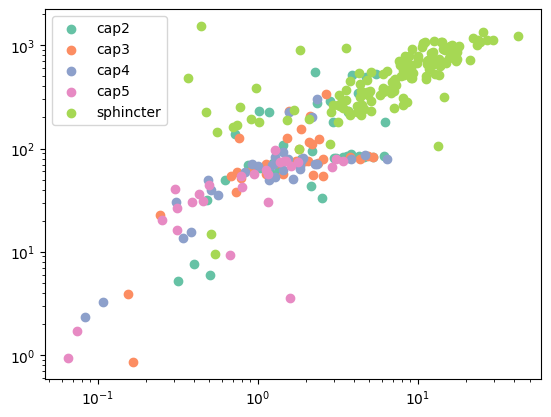

In [6]:
t = raw.dropna(subset=["speed", "flux"])
for treatment, sub in t.groupby("vessel"):
    plt.scatter(sub["speed"], sub["flux"], label=treatment)
plt.legend()
plt.semilogx()
plt.semilogy()

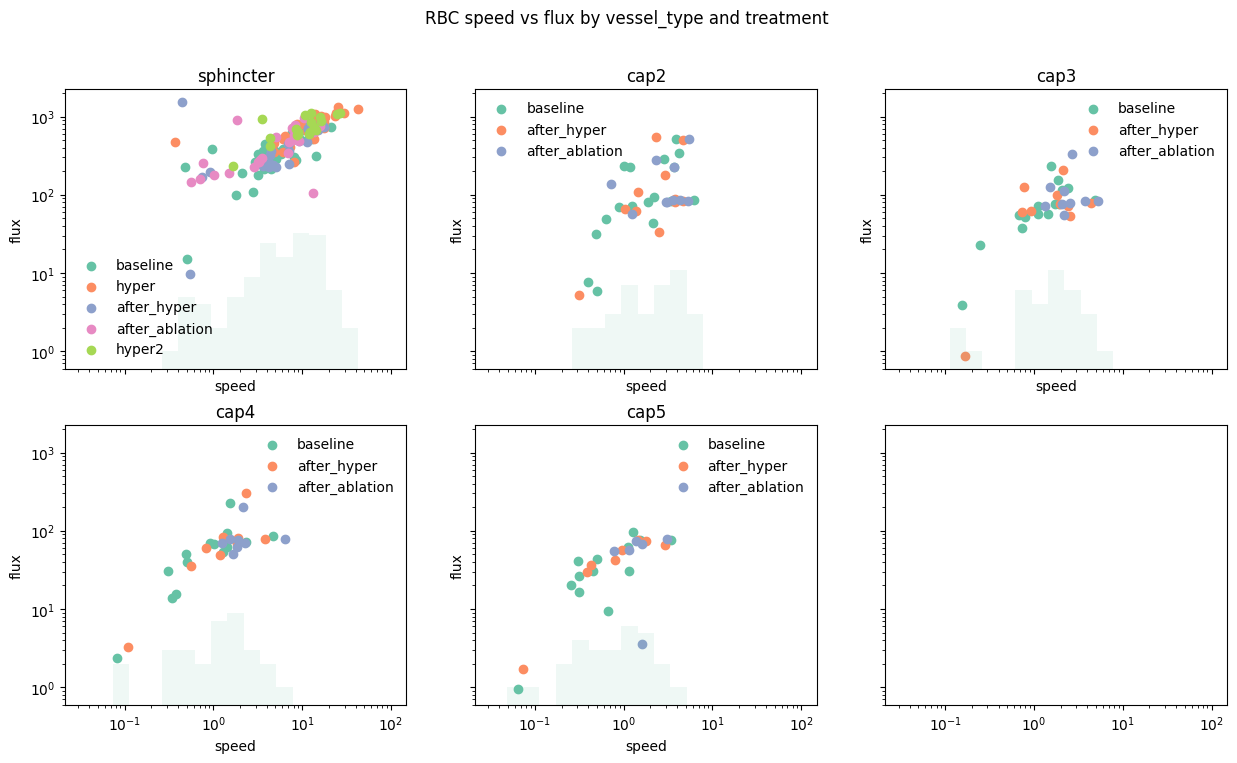

In [7]:
f, axes = plt.subplots(2, 3, figsize=[15, 8], sharex=True, sharey=True)
axes = axes.ravel()

G1 = "vessel_type"
G2 = "treatment"
title = f"RBC speed vs flux by {G1} and {G2}"

for ax, g1 in zip(axes, msts["speed"].dropna(subset=["flux"])[G1].unique()):
    subdf = msts["speed"].loc[lambda df: df[G1] == g1]
    for g2, subsubdf in subdf.groupby(G2, observed=True):
        ax.scatter(subsubdf["speed"], subsubdf["flux"], label=g2)
    ax.hist(subdf["speed"], bins=np.logspace(-1.5, 2, 20), alpha=0.1)
    ax.legend(frameon=False)
    ax.semilogx()
    ax.semilogy()
    ax.set(title=g1, xlabel="speed", ylabel="flux")

f.suptitle(title)
f.savefig(os.path.join(PLOTS_DIR, f"{title.lower().replace(' ', '-')}.png"), bbox_inches="tight")

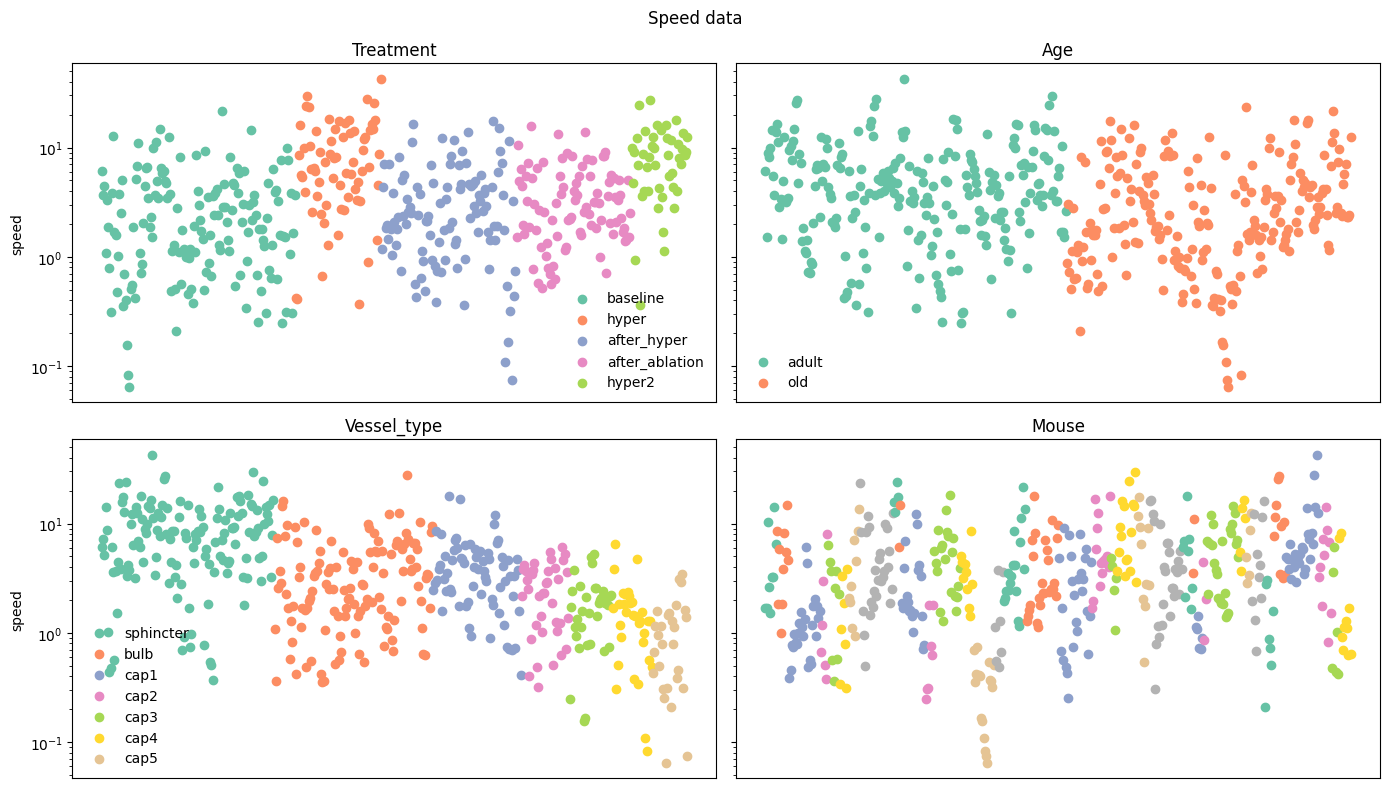

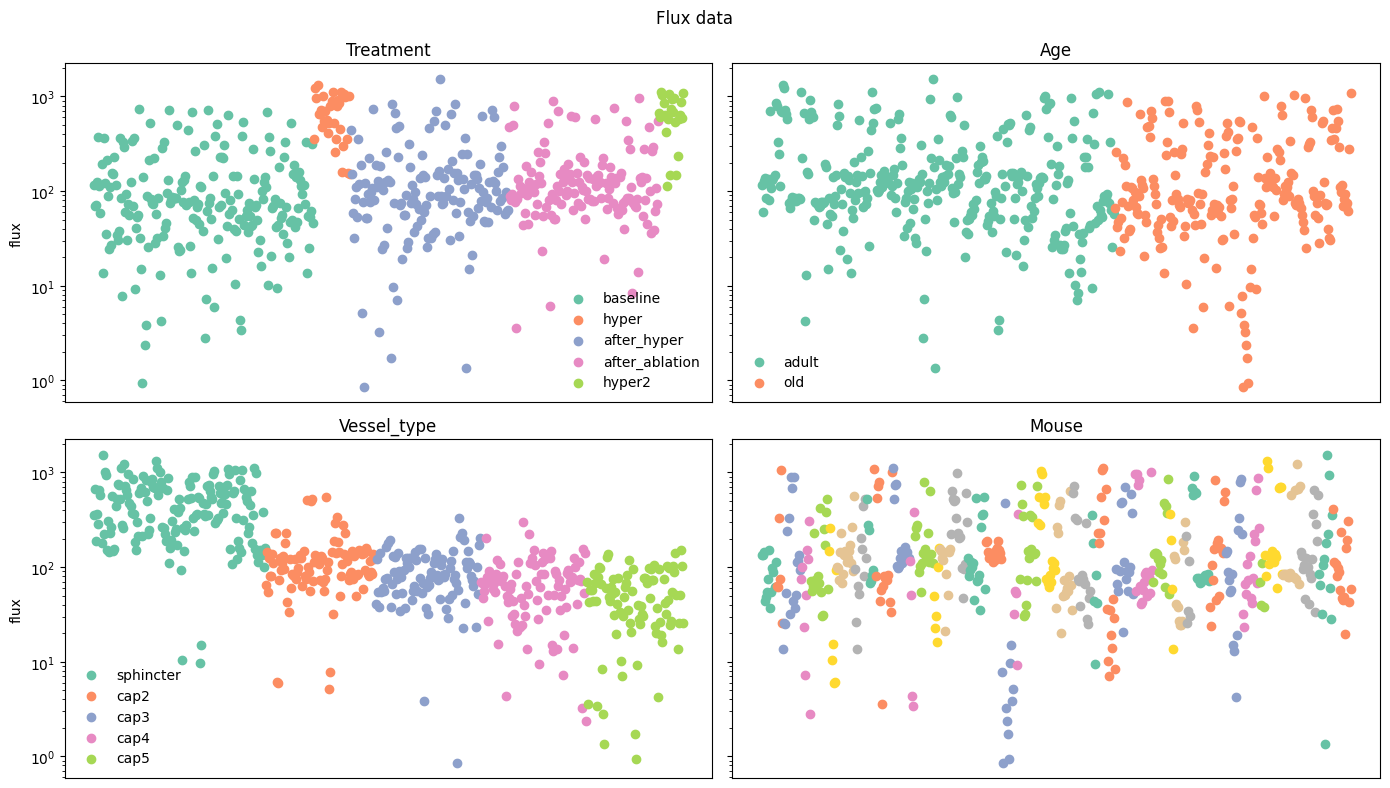

In [8]:
for ycol in ["speed", "flux"]:
    
    obs = msts[ycol][ycol]
    
    f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
    axes = axes.ravel()
    for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
        sct = plot_obs(ax, obs, msts[ycol][col])
        if col != "mouse":
            ax.legend(frameon=False);
        if i % 2 == 0:
            ax.set_ylabel(ycol);
        ax.set_xticks([])
        ax.set_title(col.capitalize())
        ax.semilogy()
    f.suptitle(f"{ycol.capitalize()} data");
    f.tight_layout()
    f.savefig(os.path.join(PLOTS_DIR, f"flow-{ycol}-measurements.png"), bbox_inches="tight")


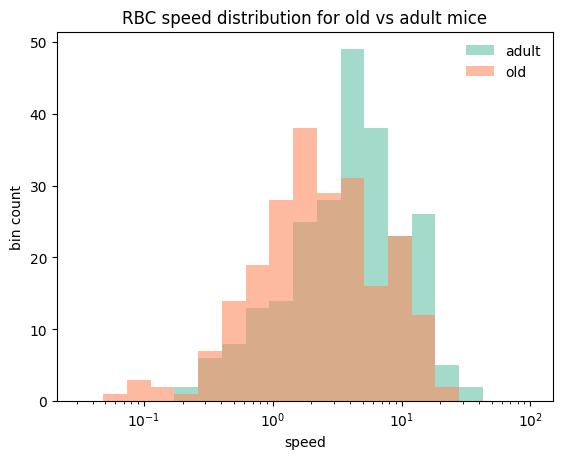

In [9]:
f, ax = plt.subplots()

for age, subdf in msts["speed"].groupby("age", observed=True):
    ax.hist(subdf["speed"], label=age, bins=np.logspace(-1.5, 2, 20), alpha=0.6);
ax.semilogx()
ax.legend(frameon=False);
ax.set(title="RBC speed distribution for old vs adult mice", xlabel="speed", ylabel="bin count");

f.savefig(os.path.join(PLOTS_DIR, "rbc-speed-vs-age.png"))

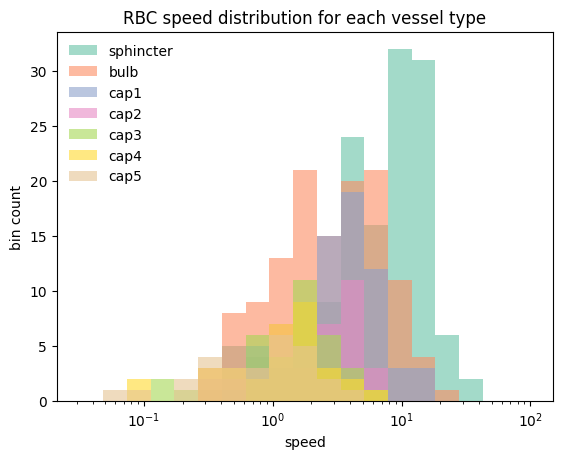

In [10]:
f, ax = plt.subplots()

for age, subdf in msts["speed"].groupby("vessel_type", observed=True):
    ax.hist(subdf["speed"], label=age, bins=np.logspace(-1.5, 2, 20), alpha=0.6);
ax.semilogx()
ax.legend(frameon=False);
ax.set(title="RBC speed distribution for each vessel type", xlabel="speed", ylabel="bin count");

f.savefig(os.path.join(PLOTS_DIR, "rbc-speed-vs-vessel-type.png"))

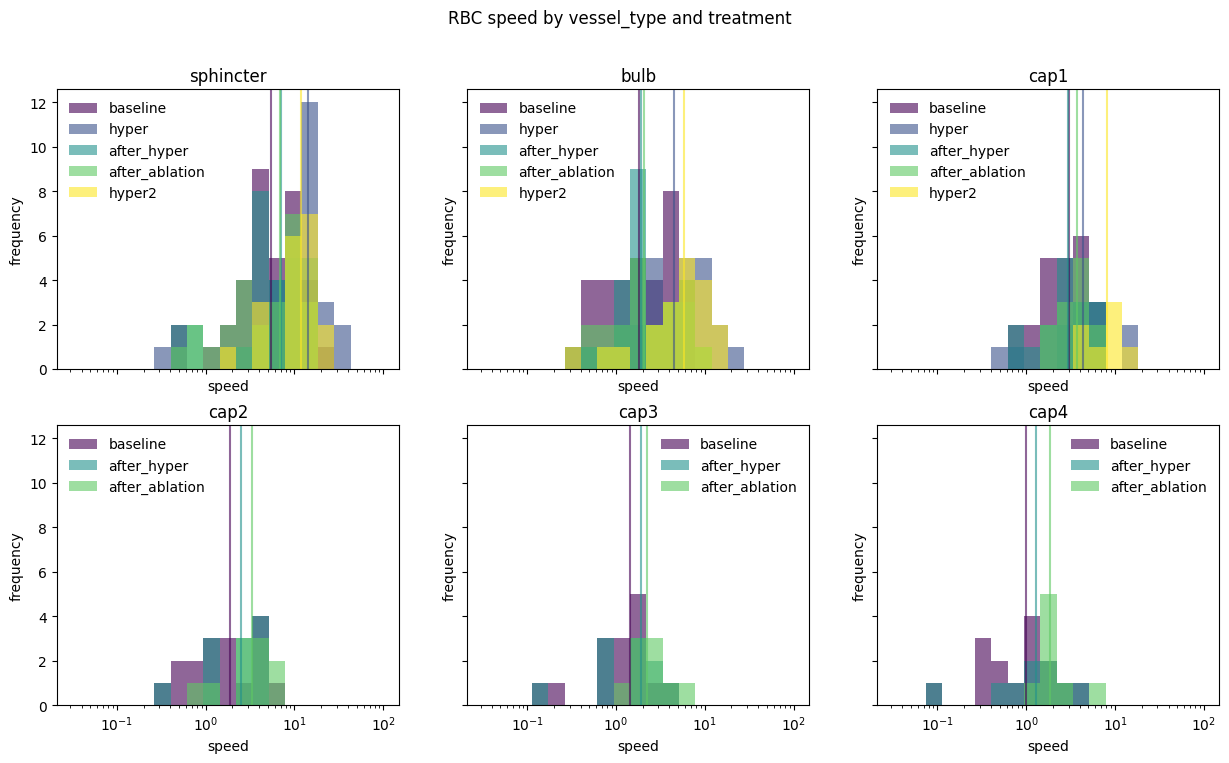

In [11]:
cmap = plt.get_cmap('viridis')

def cats_to_cols(cats, cmap):
    return dict(zip(cats, cmap(np.linspace(0, 1, len(cats)))))

treatment_to_color = cats_to_cols(msts["speed"]["treatment"].cat.categories, cmap)

f, axes = plt.subplots(2, 3, figsize=[15, 8], sharex=True, sharey=True)
axes = axes.ravel()

G1 = "vessel_type"
G2 = "treatment"
title = f"RBC speed by {G1} and {G2}"

for ax, g1 in zip(axes, msts["speed"].dropna(subset=["speed"])[G1].unique()):
    subdf = msts["speed"].loc[lambda df: df[G1] == g1]
    for g2, subsubdf in subdf.groupby(G2, observed=True):
        h = ax.hist(subsubdf["speed"], bins=np.logspace(-1.5, 2, 20), alpha=0.6, label=g2, color=treatment_to_color[g2])
        ax.axvline(subsubdf["speed"].median(), color=h[2][0].get_facecolor())
    ax.legend(frameon=False)
    ax.semilogx()
    ax.set(title=g1, xlabel="speed", ylabel="frequency")

f.suptitle(title);
f.savefig(os.path.join(PLOTS_DIR, f"{title.lower().replace(' ', '-')}.png"), bbox_inches="tight")

In [12]:
msts["speed"].groupby(["vessel_type", "treatment"])["speed"].mean().unstack("vessel_type")

/var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/ipykernel_55512/1919390266.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  msts["speed"].groupby(["vessel_type", "treatment"])["speed"].mean().unstack("vessel_type")


vessel_type,sphincter,bulb,cap1,cap2,cap3,cap4,cap5
treatment,,,,,,,
baseline,6.733814,2.528891,3.090758,2.163653,1.518498,1.206113,0.828489
hyper,14.266310,6.166937,5.475803,NaN,NaN,NaN,NaN
after_hyper,7.261837,2.761624,3.288263,2.622123,1.780132,1.546503,1.099711
after_ablation,6.142304,3.075481,3.956487,3.275713,2.625419,2.384274,1.608535
hyper2,11.612087,6.121866,8.589743,NaN,NaN,NaN,NaN


arviz - WARNING - Array contains NaN-value.
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:307: FutureWarn

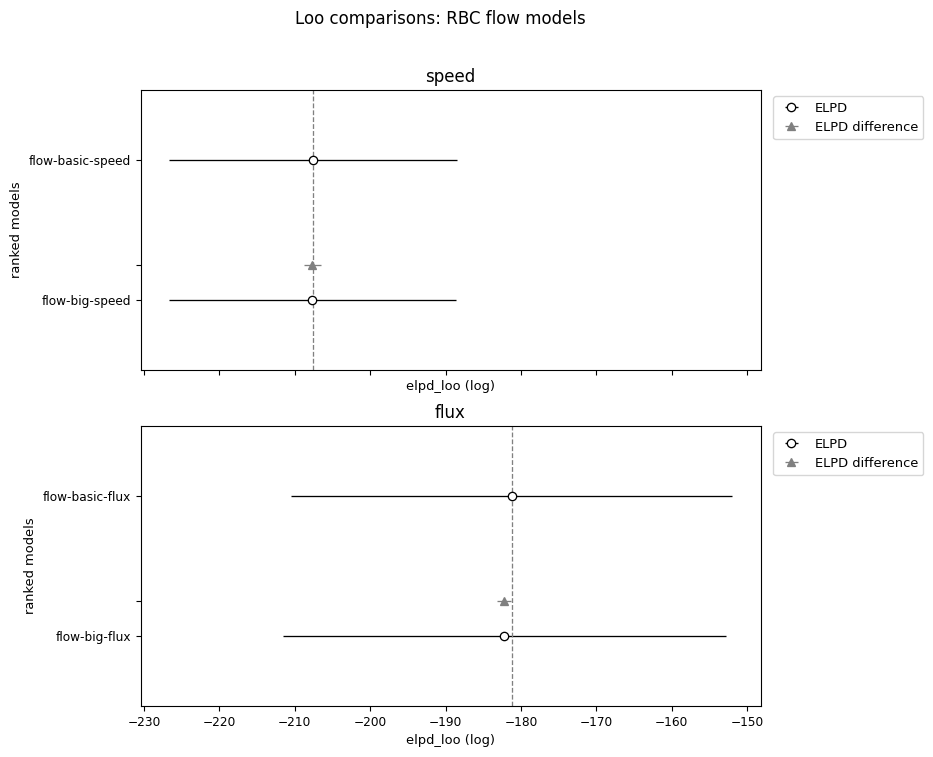

In [13]:
speed_comp = az.compare({k: v for k, v in idatas.items() if "speed" in k})
flux_comp = az.compare({k: v for k, v in idatas.items() if "flux" in k})

f, axes = plt.subplots(2, 1, figsize=[8, 8], sharex=True)
for name, comp_i, ax in zip(["speed", "flux"], [speed_comp, flux_comp], axes):
    az.plot_compare(comp_i, ax=ax);
    ax.set(title=name)
f.suptitle("Loo comparisons: RBC flow models")
f.savefig(os.path.join(PLOTS_DIR, "flow-loo.png"), bbox_inches="tight")

In [14]:
for idata_name, idata in idatas.items():
    print(
        f"Number of diverging transitions for inference {idata_name}: " 
        +  str(idata.sample_stats.diverging.values.sum())
)

Number of diverging transitions for inference flow-basic-speed: 0
Number of diverging transitions for inference flow-basic-flux: 0
Number of diverging transitions for inference flow-big-speed: 0
Number of diverging transitions for inference flow-big-flux: 0


# Inspect samples


Try a different model for the interaction effect - maybe being shrunk too hard towards zero.

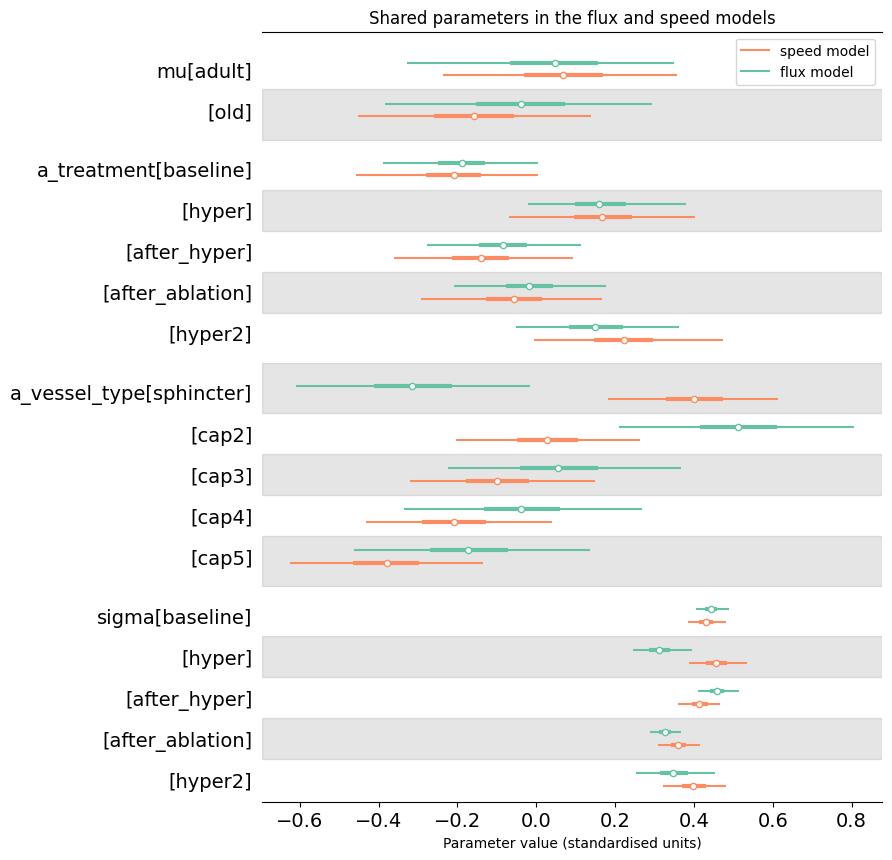

In [15]:
vars = ["mu", "a_treatment", "a_vessel_type", "sigma"]
f, ax = plt.subplots(figsize=[8, 10], sharex=True)
az.plot_forest(
    [idatas["flow-basic-flux"], idatas["flow-basic-speed"]],
    model_names=["flux model", "speed model"],
    coords={"vessel_type": ["sphincter", "cap2", "cap3", "cap4", "cap5"]},
    ax=ax,
    combined=True,
    var_names=vars,
);
ax.set(title="Shared parameters in the flux and speed models", xlabel="Parameter value (standardised units)");
f.savefig(os.path.join(PLOTS_DIR, f"flow-shared-parameters.png"), bbox_inches="tight")

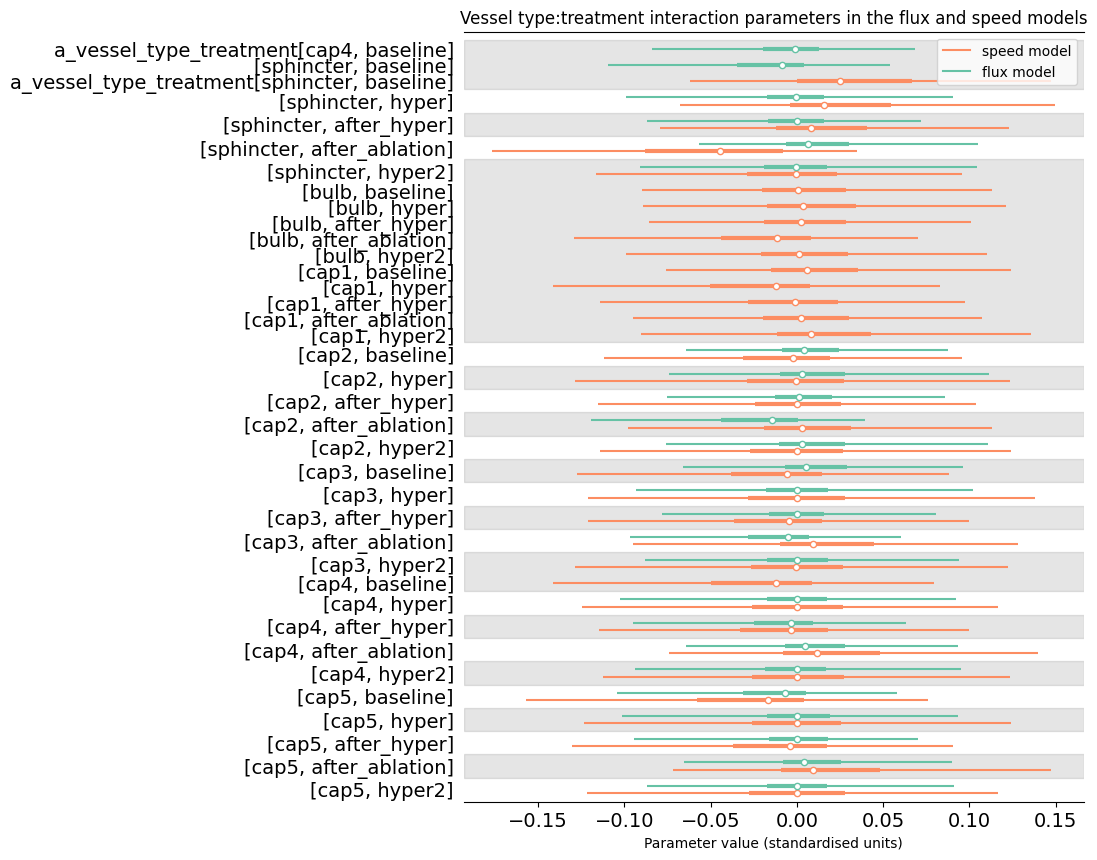

In [16]:
f, ax = plt.subplots(figsize=[8, 10], sharex=True)
az.plot_forest(
    [idatas["flow-big-flux"], idatas["flow-big-speed"]],
    model_names=["flux model", "speed model"],
    ax=ax,
    combined=True,
    var_names=["a_vessel_type_treatment"],
);
ax.set(title="Vessel type:treatment interaction parameters in the flux and speed models", xlabel="Parameter value (standardised units)");
f.savefig(os.path.join(PLOTS_DIR, f"flow-interaction-parameters.png"), bbox_inches="tight")

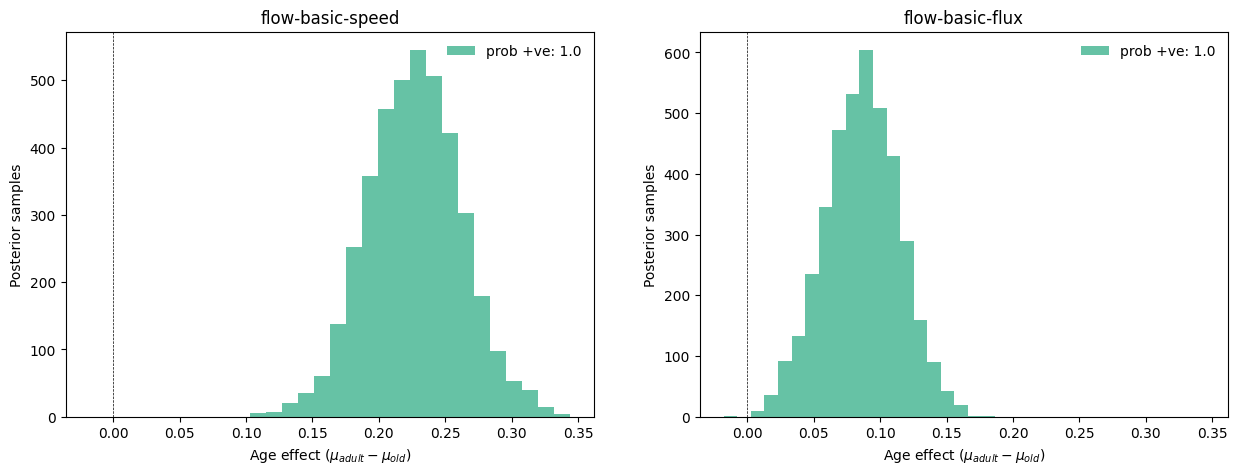

In [21]:
f, axes = plt.subplots(1, 2, figsize=[15, 5], sharex=True)

for ax, (idata_name, idata) in zip(axes, idatas.items()):
    t = idata.posterior["mu"].sel(age="adult") - idata.posterior["mu"].sel(age="old")
    pr = str(round((t > 0).mean().values[()], 3))
    ax.hist(t.values.flatten(), bins=20, label=f"prob +ve: {pr}");
    ax.set(title=idata_name, ylabel="Posterior samples", xlabel="Age effect ($\\mu_{adult} - \\mu_{old}$)")
    ax.legend(frameon=False)
    ax.axvline(0, color="black", zorder=0, linestyle="--", linewidth=0.5);
f.savefig(os.path.join(PLOTS_DIR, "flow-age-effects.png"), bbox_inches="tight")

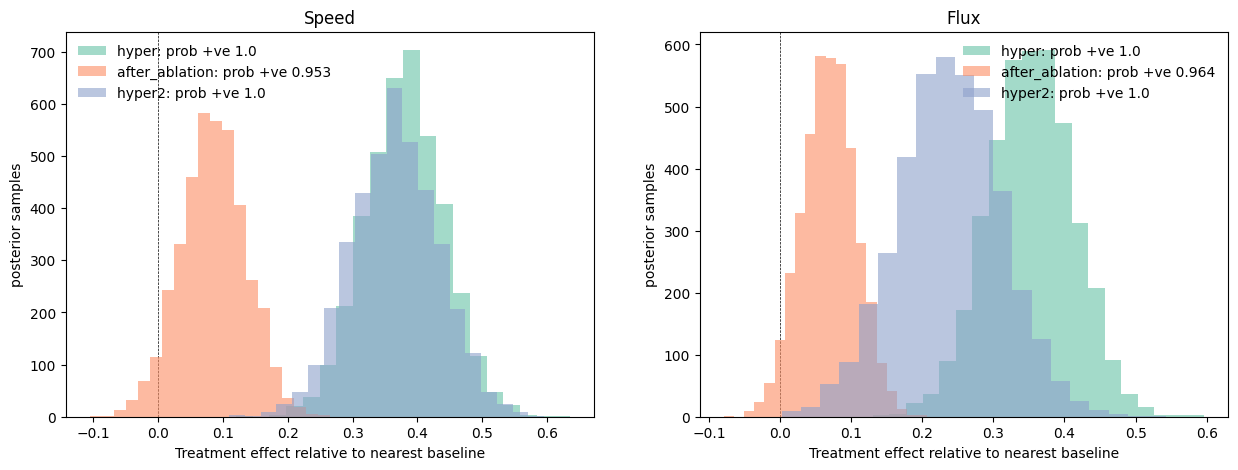

In [22]:
f, axes = plt.subplots(1, 2, figsize=[15, 5])

for ax, (idata_name, idata) in zip(axes, idatas.items()):
    for before, after in zip(
        ["baseline", "after_hyper", "after_hyper"], 
        ["hyper", "after_ablation", "hyper2"]
    ):
        t = (
            idata.posterior["a_treatment"].sel(treatment=after) 
            - idata.posterior["a_treatment"].sel(treatment=before)
        )
        pr = str(round((t > 0).mean().values[()], 3))
        ax.hist(t.values.flatten(), bins=20, label=f"{after}: prob +ve {pr}", alpha=0.6);
    ax.set(
        title=idata_name.split("-")[-1].capitalize(),
        ylabel="posterior samples",
        xlabel="Treatment effect relative to nearest baseline"
    )
    ax.axvline(0, color="black", zorder=0, linestyle="--", linewidth=0.5);
    ax.legend(frameon=False)
f.savefig(os.path.join(PLOTS_DIR, "flow-treatment-effects.png"), bbox_inches="tight")

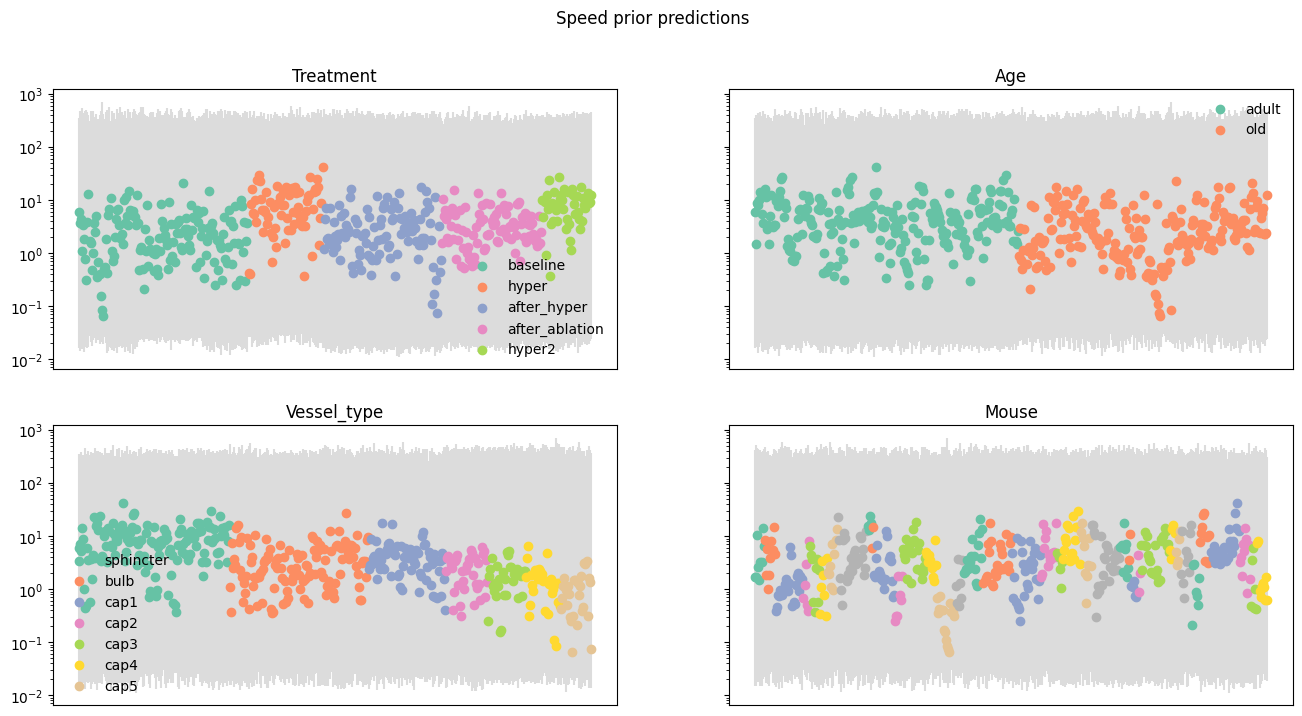

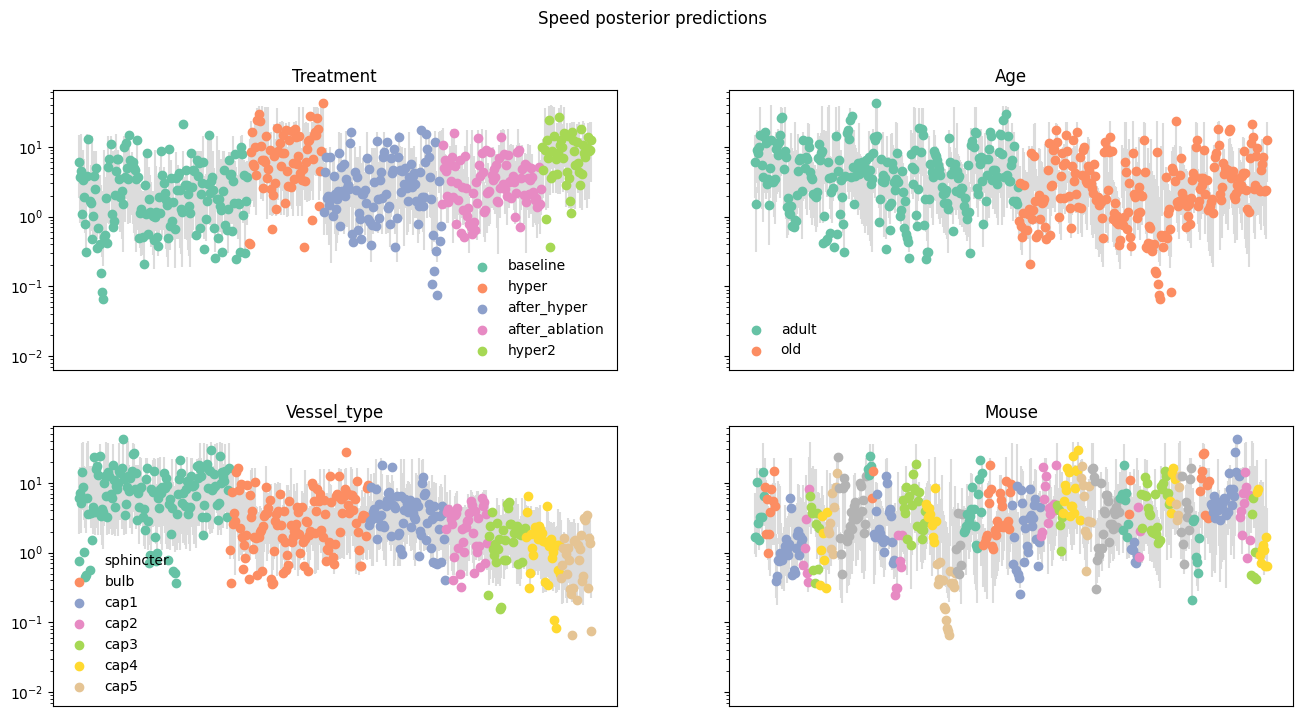

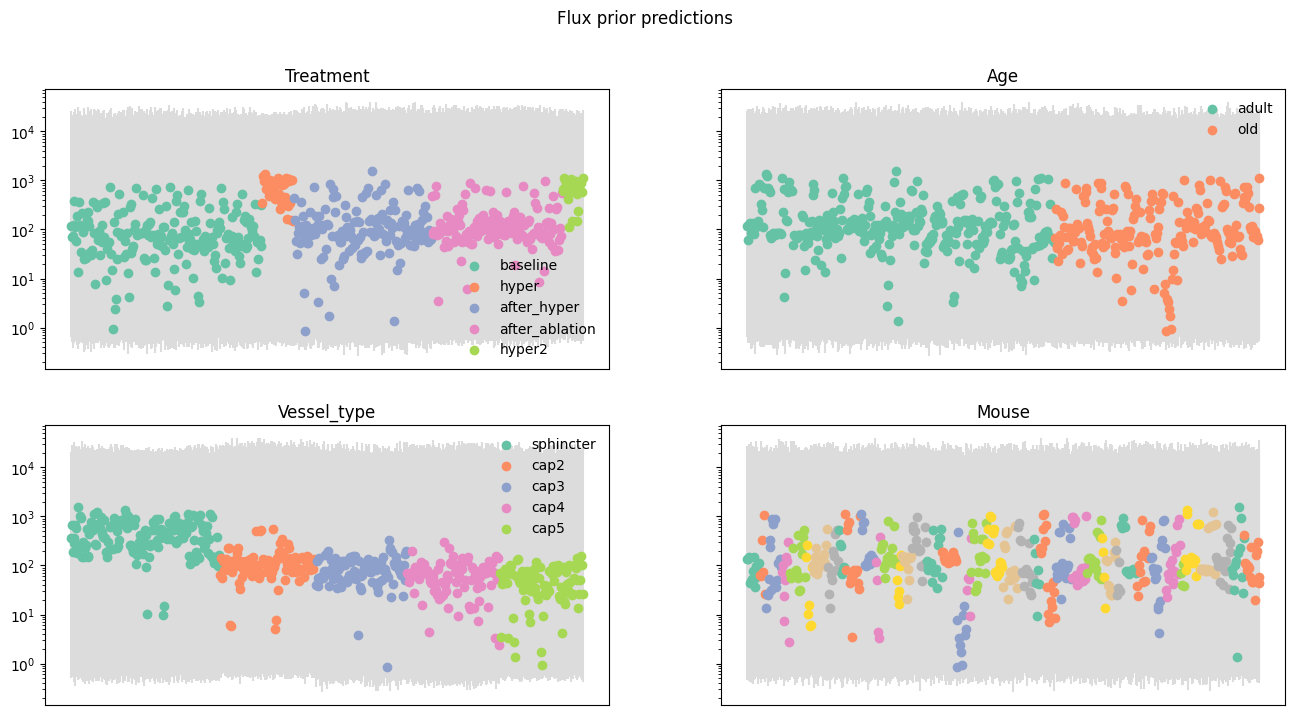

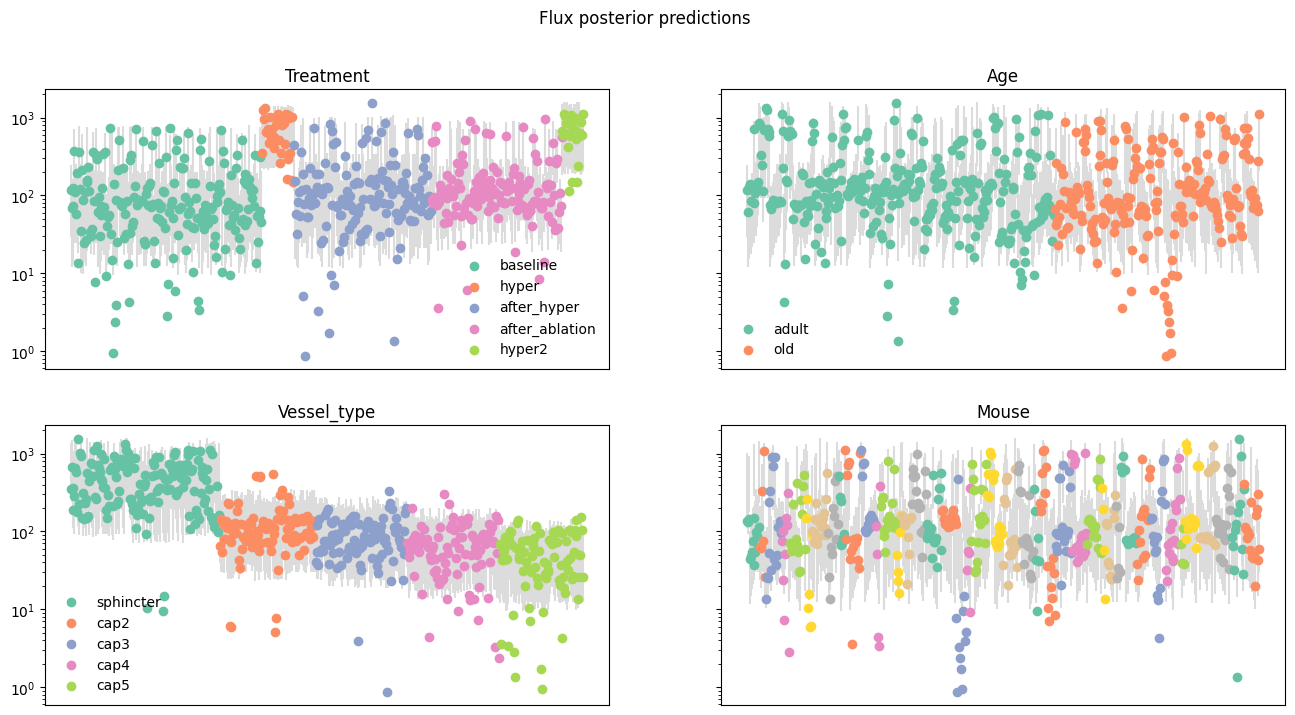

In [19]:
for ycol, (idata_name, idata), (msts_name, msts_i) in zip(
    ["speed", "flux"], idatas.items(), msts.items()
):
    for group, mode in zip(
        [idata.prior_predictive, idata.posterior_predictive], ["prior", "posterior"]
    ):
        yrep = group["yrep"]
        obs = msts[ycol]
        f, axes = plt.subplots(2, 2, figsize=[16, 8], sharey=True)
        axes = axes.ravel()
        for ax, col in zip(axes, ["treatment", "age", "vessel_type", "mouse"]):
            obs = plot_obs(ax, msts_i[ycol], cat=msts_i[col])
            lines = plot_predictive(ax, yrep, cat=msts_i[col], zorder=-1)
            if col != "mouse":
                ax.legend(frameon=False)
            ax.set_xticks([])
            ax.semilogy()
            ax.set(title=col.capitalize())
        f.suptitle(f"{ycol.capitalize()} {mode} predictions")
        f.savefig(
            os.path.join(PLOTS_DIR, f"{idata_name}-{mode}-predictive.png"), 
            bbox_inches="tight"
        )